In [1]:
pip install --quiet --upgrade torch torchvision pytorch-lightning wandb matplotlib pillow testresources

Note: you may need to restart the kernel to use updated packages.


## 1 - forest-vs-houses - categorical

### load data

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

on cocalc the data is in ``/data``

data sources (to use at home):
- train/test: https://paste.madflex.de/YtmeRXrY#houses-vs-forest.zip (500mb)
- test2: https://paste.madflex.de/pyHrvXyG#test2_f-vs-h.zip (100mb)
- test3: https://paste.madflex.de/La6ZMHvf#test3_f-vs-h.zip (90mb)

In [3]:
DATA_DIR = "/data/houses-vs-forest"

In [43]:
!ls /data/houses-vs-forest/test3/houses

G0021068.JPG  G0021546.JPG  G0042882.JPG  G0077563.JPG	G0109966.JPG
G0021170.JPG  G0042712.JPG  G0054872.JPG  G0077705.JPG
G0021184.JPG  G0042762.JPG  G0056373.JPG  G0088211.JPG
G0021264.JPG  G0042813.JPG  G0067018.JPG  G0088454.JPG
G0021422.JPG  G0042836.JPG  G0067028.JPG  G0109938.JPG


show example image (commented because this increases the notebook size)

In [5]:
# img = Image.open(f"{DATA_DIR}/test/houses/G0023671.JPG")
# plt.imshow(img)
# plt.show()

In [6]:
import torch
import torchvision

In [7]:
import pytorch_lightning as lightning
lightning.seed_everything(42)

Global seed set to 42


42

In [8]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(100),
    torchvision.transforms.ToTensor()
])

#### training data

In [9]:
image_train = torchvision.datasets.ImageFolder(f"{DATA_DIR}/train", transform=transforms)

In [10]:
image_count = 107

In [11]:
train_ds, validation_ds = torch.utils.data.random_split(image_train,[(image_count-15)*2, 15*2])

#### test data

In [12]:
# images from the same tour/day
test_ds = torchvision.datasets.ImageFolder(f"{DATA_DIR}/test", transform=transforms)

In [13]:
# images from *another* tour/day
test2_ds = torchvision.datasets.ImageFolder(f"{DATA_DIR}/test2", transform=transforms)

In [14]:
# images from another tour/day and another bike
test3_ds = torchvision.datasets.ImageFolder(f"{DATA_DIR}/test3", transform=transforms)

In [15]:
all_test_ds = test_ds + test2_ds + test3_ds

In [16]:
len(all_test_ds)

108

In [17]:
image_train.classes

['forest', 'houses']

In [18]:
all_test_ds[0][1]

0

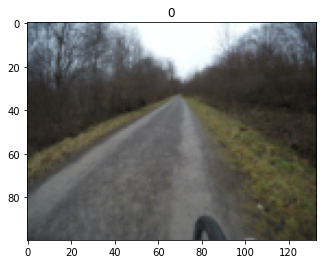

In [19]:
number = 3
plt.imshow(all_test_ds[number][0].permute(1, 2, 0))
plt.title('%i' % all_test_ds[number][1])
plt.show()

In [20]:
import wandb
wandb.login()

wandb: Currently logged in as: mfa (use `wandb login --relogin` to force relogin)


True

### Model (categorical)

In [21]:
from torchmetrics import Accuracy

Some background about CNNs:
- https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks
- https://deepai.org/machine-learning-glossary-and-terms/convolutional-neural-network

In [22]:
train_ds[0][0].size()

torch.Size([3, 100, 133])

In [23]:
class ForestHousesCategoricalModel(lightning.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.batch_size = 16

        channels, width, height = train_ds[0][0].size()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(4),
            torch.nn.Dropout(0.5),
            torch.nn.Flatten(),
            #  500x + channels=20, maxpool=2 -> 1653360
            #  100x + channels=20, maxpool=2 -> 63700
            #  100x + channels=50, maxpool=2 -> 159250
            #  100x + channels=50, maxpool=4 -> 38400
            #  100x + channels=20, maxpool=4 -> 15360
            torch.nn.Linear(15360, 2),
        )
        self.loss = torch.nn.CrossEntropyLoss()

        acc = Accuracy()
        self.train_acc = acc.clone()
        self.valid_acc = acc.clone()

    def forward(self, x):
        return self.model(x)

    def step(self, batch, batch_idx, name):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log(f"{name}/loss", loss)

        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        
        if name == "train":
            self.train_acc(preds, y)
            self.log(f"{name}/acc", self.train_acc)
        else:
            self.valid_acc(preds, y)
            self.log(f"{name}/acc", self.valid_acc)

        return {"loss": loss}
    
    def training_step(self, batch, batch_nb):
        return self.step(batch, batch_nb, name="train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="val")
    
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(train_ds, batch_size=self.batch_size)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(validation_ds, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(all_test_ds, batch_size=self.batch_size)

In [24]:
model_categorical = ForestHousesCategoricalModel()
model_categorical

ForestHousesCategoricalModel(
  (model): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=15360, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
  (train_acc): Accuracy()
  (valid_acc): Accuracy()
)

In [25]:
wandb_logger = lightning.loggers.WandbLogger(project="workshop-p2--FvsH--cat")
wandb_logger.watch(model_categorical, log="all")
trainer_categorical = lightning.Trainer(gpus=0, max_epochs=10, logger=wandb_logger)
trainer_categorical.fit(model_categorical)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 31.3 K
1 | loss      | CrossEntropyLoss | 0     
2 | train_acc | Accuracy         | 0     
3 | valid_acc | Accuracy         | 0     
-----------------------------------------------
31.3 K    Trainable params
0         Non-trainable params
31.3 K    Total params
0.125     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [26]:
trainer_categorical.test(ckpt_path='best')

Restoring states from the checkpoint path at /home/mfa/machine-learning-workshop/part2/workshop-p2--FvsH--cat/7sothvxb/checkpoints/epoch=9-step=119.ckpt
Loaded model weights from checkpoint at /home/mfa/machine-learning-workshop/part2/workshop-p2--FvsH--cat/7sothvxb/checkpoints/epoch=9-step=119.ckpt
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.7870370149612427, 'test/loss': 0.5997459292411804}
--------------------------------------------------------------------------------


[{'test/loss': 0.5997459292411804, 'test/acc': 0.7870370149612427}]

In [27]:
wandb.finish()

epoch,▁▂▂▃▄▄▅▅▆▇▇▇█
test/acc,▁
test/loss,▁
train/acc,▁█
train/loss,█▁
trainer/global_step,▁▂▃▃▃▄▅▆▆▇▇██
val/acc,▁▇████████
val/loss,█▅▃▂▂▁▁▁▁▁
epoch,10
test/acc,0.78704
test/loss,0.59975


In [28]:
# alternative to reshape without knowing the dimensions
img = test_ds[0][0][None, :]

In [29]:
img.size()

torch.Size([1, 3, 100, 133])

In [30]:
import termcolor

In [31]:
def test_result(idx, image, model):
    img = image[0][None, :]
    r = model(img)
    is_correct = bool(image[1] == torch.argmax(r))
    is_correct = termcolor.colored(is_correct, "green" if is_correct else "red")
    return " ".join([str(i) for i in [idx, image[1], test_ds.classes[image[1]], is_correct, torch.argmax(r), r]])

In [32]:
for idx, item in enumerate(test_ds):
    print(test_result(idx, item, trainer_categorical.model))

0 0 forest True tensor(0) tensor([[ 0.2663, -0.3796]], grad_fn=<AddmmBackward0>)
1 0 forest True tensor(0) tensor([[ 1.8222, -1.9089]], grad_fn=<AddmmBackward0>)
2 0 forest True tensor(0) tensor([[ 2.1652, -2.1790]], grad_fn=<AddmmBackward0>)
3 0 forest True tensor(0) tensor([[ 1.8663, -1.8476]], grad_fn=<AddmmBackward0>)
4 0 forest True tensor(0) tensor([[ 2.3496, -2.5498]], grad_fn=<AddmmBackward0>)
5 0 forest True tensor(0) tensor([[ 1.3001, -1.2972]], grad_fn=<AddmmBackward0>)
6 0 forest True tensor(0) tensor([[ 2.8249, -2.9902]], grad_fn=<AddmmBackward0>)
7 0 forest True tensor(0) tensor([[ 1.7455, -1.9884]], grad_fn=<AddmmBackward0>)
8 0 forest True tensor(0) tensor([[ 2.0554, -2.0904]], grad_fn=<AddmmBackward0>)
9 0 forest True tensor(0) tensor([[ 1.9758, -2.1721]], grad_fn=<AddmmBackward0>)
10 1 houses True tensor(1) tensor([[-1.1121,  1.3902]], grad_fn=<AddmmBackward0>)
11 1 houses True tensor(1) tensor([[-1.6234,  1.5733]], grad_fn=<AddmmBackward0>)
12 1 houses True tensor(1)

In [33]:
for idx, item in enumerate(test2_ds):
    print(test_result(idx, item, trainer_categorical.model))

0 0 forest True tensor(0) tensor([[ 1.2319, -1.2127]], grad_fn=<AddmmBackward0>)
1 0 forest True tensor(0) tensor([[ 1.7231, -1.8192]], grad_fn=<AddmmBackward0>)
2 0 forest False tensor(1) tensor([[-1.0754,  1.0351]], grad_fn=<AddmmBackward0>)
3 0 forest False tensor(1) tensor([[-0.4455,  0.2473]], grad_fn=<AddmmBackward0>)
4 0 forest True tensor(0) tensor([[ 1.8709, -1.8220]], grad_fn=<AddmmBackward0>)
5 0 forest True tensor(0) tensor([[ 2.5683, -2.4219]], grad_fn=<AddmmBackward0>)
6 0 forest True tensor(0) tensor([[ 0.8763, -0.9510]], grad_fn=<AddmmBackward0>)
7 0 forest True tensor(0) tensor([[ 0.9395, -0.9447]], grad_fn=<AddmmBackward0>)
8 0 forest False tensor(1) tensor([[-0.9938,  0.9235]], grad_fn=<AddmmBackward0>)
9 0 forest True tensor(0) tensor([[ 0.2479, -0.2415]], grad_fn=<AddmmBackward0>)
10 0 forest True tensor(0) tensor([[ 0.3621, -0.3231]], grad_fn=<AddmmBackward0>)
11 0 forest True tensor(0) tensor([[ 1.7188, -1.6429]], grad_fn=<AddmmBackward0>)
12 0 forest True tensor

In [34]:
for idx, item in enumerate(test3_ds):
    print(test_result(idx, item, trainer_categorical.model))

0 0 forest False tensor(1) tensor([[-0.6518,  0.5386]], grad_fn=<AddmmBackward0>)
1 0 forest False tensor(1) tensor([[-1.1508,  1.0810]], grad_fn=<AddmmBackward0>)
2 0 forest False tensor(1) tensor([[-2.6155,  2.6391]], grad_fn=<AddmmBackward0>)
3 0 forest False tensor(1) tensor([[-0.8300,  0.5967]], grad_fn=<AddmmBackward0>)
4 0 forest False tensor(1) tensor([[-0.6251,  0.7260]], grad_fn=<AddmmBackward0>)
5 0 forest False tensor(1) tensor([[-0.9106,  0.8477]], grad_fn=<AddmmBackward0>)
6 0 forest False tensor(1) tensor([[-0.9305,  0.9121]], grad_fn=<AddmmBackward0>)
7 0 forest False tensor(1) tensor([[-1.1129,  0.8192]], grad_fn=<AddmmBackward0>)
8 0 forest False tensor(1) tensor([[-1.8555,  1.7542]], grad_fn=<AddmmBackward0>)
9 0 forest True tensor(0) tensor([[ 0.3702, -0.3716]], grad_fn=<AddmmBackward0>)
10 0 forest False tensor(1) tensor([[-1.5137,  1.4858]], grad_fn=<AddmmBackward0>)
11 0 forest False tensor(1) tensor([[-2.0860,  2.0245]], grad_fn=<AddmmBackward0>)
12 0 forest Fal

## 2 - forest-vs-houses -  binary

the same model, but changed to a binary model

In [35]:
class ForestHousesBinaryModel(lightning.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.batch_size = 16

        channels, width, height = train_ds[0][0].size()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(4),
            torch.nn.Dropout(0.5),
            torch.nn.Flatten(),
            #  500x + channels=20, maxpool=2 -> 1653360
            #  100x + channels=20, maxpool=2 -> 63700
            #  100x + channels=50, maxpool=2 -> 159250
            #  100x + channels=50, maxpool=4 -> 38400
            #  100x + channels=20, maxpool=4 -> 15360
            torch.nn.Linear(15360, 1),  # <-- 1 (because binary)
            torch.nn.Sigmoid(), # sideeffect: bring output values in correct range (0..1)          
        )

        # different loss for binary
        self.loss = torch.nn.BCELoss()

        # alternative, works with values outside of range (0..1) but also results in values outside of range
        # self.loss = torch.nn.BCEWithLogitsLoss()  
        
        acc = Accuracy()
        self.train_acc = acc.clone()
        self.valid_acc = acc.clone()

    def forward(self, x):
        return self.model(x)

    def step(self, batch, batch_idx, name):
        x, y = batch
        y_hat = self.forward(x)
        
        # transform y
        # [1, 2, 3] -> [[1], [2], [3]]
        y.unsqueeze_(1)
        
        # cast dtype:int to dtype:float for y (target)
        loss = self.loss(y_hat, y.float())
        
        self.log(f"{name}/loss", loss)

        logits = self(x)
        # no argmax needed -> logits are result
        
        # target stays here as dtype:int
        if name == "train":
            self.train_acc(logits, y)
            self.log(f"{name}/acc", self.train_acc)
        else:
            self.valid_acc(logits, y)
            self.log(f"{name}/acc", self.valid_acc)

        return {"loss": loss}
    
    def training_step(self, batch, batch_nb):
        return self.step(batch, batch_nb, name="train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="val")
    
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(train_ds, batch_size=self.batch_size)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(validation_ds, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(all_test_ds, batch_size=self.batch_size)

In [36]:
model_binary = ForestHousesBinaryModel()
model_binary

ForestHousesBinaryModel(
  (model): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=15360, out_features=1, bias=True)
    (6): Sigmoid()
  )
  (loss): BCELoss()
  (train_acc): Accuracy()
  (valid_acc): Accuracy()
)

In [37]:
wandb_logger = lightning.loggers.WandbLogger(project="workshop-p2--FvsH--bin")
wandb_logger.watch(model_binary, log="all")
trainer_binary = lightning.Trainer(gpus=0, max_epochs=10, logger=wandb_logger)
trainer_binary.fit(model_binary)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(

  | Name      | Type       | Params
-----------------------------------------
0 | model     | Sequential | 15.9 K
1 | loss      | BCELoss    | 0     
2 | train_acc | Accuracy   | 0     
3 | valid_acc | Accuracy   | 0     
-----------------------------------------
15.9 K    Trainable params
0         Non-trainable params
15.9 K    Total params
0.064     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [38]:
trainer_binary.test(ckpt_path='best')

Restoring states from the checkpoint path at /home/mfa/machine-learning-workshop/part2/workshop-p2--FvsH--bin/8zp4lao3/checkpoints/epoch=9-step=119.ckpt
Loaded model weights from checkpoint at /home/mfa/machine-learning-workshop/part2/workshop-p2--FvsH--bin/8zp4lao3/checkpoints/epoch=9-step=119.ckpt
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.7777777910232544, 'test/loss': 0.5638598203659058}
--------------------------------------------------------------------------------


[{'test/loss': 0.5638598203659058, 'test/acc': 0.7777777910232544}]

In [39]:
wandb.finish()

epoch,▁▂▂▃▄▄▅▅▆▇▇▇█
test/acc,▁
test/loss,▁
train/acc,▁█
train/loss,█▁
trainer/global_step,▁▂▃▃▃▄▅▆▆▇▇██
val/acc,▁▃▄▄▆▇████
val/loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test/acc,0.77778
test/loss,0.56386


In [40]:
def test_result(idx, image, model):
    img = image[0][None, :]
    r = model(img)
    is_correct = (r[0] > 0.5) == (image[1] == 1)
    is_correct = termcolor.colored(is_correct, "green" if is_correct else "red")
    return " ".join([str(i) for i in [idx, image[1], test_ds.classes[image[1]], is_correct, r]])

Accuracy: https://torchmetrics.readthedocs.io/en/stable/references/modules.html#id3
default threshold=0.5

In [41]:
for idx, item in enumerate(all_test_ds):
    print(test_result(idx, item, trainer_binary.model))

0 0 forest tensor([False]) tensor([[0.7163]], grad_fn=<SigmoidBackward0>)
1 0 forest tensor([True]) tensor([[0.1081]], grad_fn=<SigmoidBackward0>)
2 0 forest tensor([True]) tensor([[0.0369]], grad_fn=<SigmoidBackward0>)
3 0 forest tensor([True]) tensor([[0.0263]], grad_fn=<SigmoidBackward0>)
4 0 forest tensor([True]) tensor([[0.0828]], grad_fn=<SigmoidBackward0>)
5 0 forest tensor([True]) tensor([[0.2214]], grad_fn=<SigmoidBackward0>)
6 0 forest tensor([True]) tensor([[0.0097]], grad_fn=<SigmoidBackward0>)
7 0 forest tensor([True]) tensor([[0.0339]], grad_fn=<SigmoidBackward0>)
8 0 forest tensor([True]) tensor([[0.0413]], grad_fn=<SigmoidBackward0>)
9 0 forest tensor([True]) tensor([[0.0652]], grad_fn=<SigmoidBackward0>)
10 1 houses tensor([True]) tensor([[0.8933]], grad_fn=<SigmoidBackward0>)
11 1 houses tensor([True]) tensor([[0.8701]], grad_fn=<SigmoidBackward0>)
12 1 houses tensor([True]) tensor([[0.9957]], grad_fn=<SigmoidBackward0>)
13 1 houses tensor([True]) tensor([[0.9925]], g